# Home Work 1


## Description.

Apply your knowledge about Fully-Connected NNs so far to solve several classification tasks


## Evaluation.

Along with every graded task you will see the maximum grading possible for it placed in (parenthesis). Grade might be lowered. The clear indicator that you won't get a maximum amount of points for a task is that your code does not work and/or your NN is not training. In order to obtain the maximum points you have to have sufficient accuracy >90%


### Good luck!

In [222]:
import numpy as np
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tqdm
import copy
import torch.optim as opt

## Data

This is a toy dataset. <br>
$x \in \mathbb{R}^2, y \in \{0, 1\}$

In [223]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [224]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


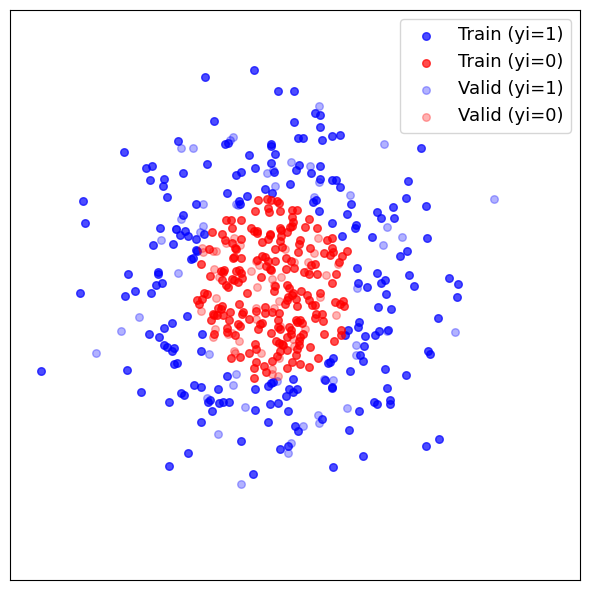

In [225]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## NN declaration (1 points)

You need to implement a class for a simple FC NN. Add as many layers and as many neurons as you'd like.

In [226]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2, 124)
        self.hidden2 = nn.Linear(124, 64)
        self.relu = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x)).squeeze()
        return x

##  Train function. (1.5 points)
Add missing parts

In [227]:
def train(model, loss, opt, n_epochs,
          batch_size, X_train, y_train,
          X_val=None, y_val=None):

    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)
    x_val_ld = DataLoader(X_val, batch_size=1) if X_val else None
    y_val_ld = DataLoader(y_val, batch_size=1) if y_val else None

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    losses = []
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(epoch, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x, y in zip(x_train_loader, y_train_loader):
                #forward
                y_pred = model(x)
                loss_val = loss(y_pred, y)
                losses.append(loss_val.item())

                opt.zero_grad()
                loss_val.backward()
                opt.step()

                ### END  CODE
                # print progress
                acc = (y_pred.round() == y).float().mean().item()

                bar.set_postfix(
                    loss=float(loss_val),
                    acc=acc
                )

        # evaluate accuracy at end of each epoch
        if X_val is not None and y_val is not None:
          model.eval()
          with torch.no_grad():
            y_pred_val = model(X_val)
            acc_val = (y_pred_val.round() == y_val).float().mean().item()
            if acc_val > best_acc:
                best_acc = acc_val
                best_weights = copy.deepcopy(model.state_dict())

            if acc_val > 0.98:
                break
    # restore model and return best accuracy

    if best_weights is not None:
        model.load_state_dict(best_weights)

    return model, losses

### Train the network. (1 point)

Train NN three times: with three different optimization algorithms. Don't forget to reinitialize model before each train. Make sure you pass the correct arguments to opt.

**Hint** It is better to have three different objects - model1, model2, and model3

In [228]:
# мне кажется, это неудобный способ...
#optims = {'optim1': torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9),# use SGD
#         'optim2': torch.optim.Adam(model.parameters(), lr=rate_learning), # use Adam
#          'optim3' = # use RMSProp
#          }

#for opt_name, opt in optims.items():
    ### Your code here
#    train(model, X_train[train], y_train[train], X_train[test], y_train[test])

    ### END CODE

In [229]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

In [230]:
model = NeuralNetwork()
loss = nn.BCELoss()
optimizer = opt.Adam(model.parameters(), lr=0.00001)
n_epochs = 10
batch_size = 8
res = train(model, loss, optimizer,
            n_epochs, batch_size, X_train_torch, y_train_torch)
model2, loss_SGD = res[0], res[1]

Epoch 0: : 0batch [00:01, ?batch/s, acc=0.375, loss=0.706]
Epoch 1: : 0batch [00:00, ?batch/s, acc=0.375, loss=0.7]
Epoch 2: : 0batch [00:00, ?batch/s, acc=0.375, loss=0.694]
Epoch 3: : 0batch [00:00, ?batch/s, acc=0.375, loss=0.688]
Epoch 4: : 0batch [00:00, ?batch/s, acc=0.5, loss=0.683]
Epoch 5: : 0batch [00:00, ?batch/s, acc=0.625, loss=0.677]
Epoch 6: : 0batch [00:00, ?batch/s, acc=0.875, loss=0.672]
Epoch 7: : 0batch [00:00, ?batch/s, acc=0.875, loss=0.668]
Epoch 8: : 0batch [00:00, ?batch/s, acc=0.875, loss=0.663]
Epoch 9: : 0batch [00:00, ?batch/s, acc=1, loss=0.659]


In [231]:
model1, loss_Adam = res[0], res[1]

In [232]:
model = NeuralNetwork()
loss = nn.BCELoss()
optimizer = opt.SGD(model.parameters(), lr=0.1, momentum=0.9)
n_epochs = 7
batch_size = 8

res = train(model, loss, optimizer,
            n_epochs, batch_size, X_train_torch, y_train_torch)
model2, loss_SGD = res[0], res[1]

Epoch 0: : 0batch [00:00, ?batch/s, acc=0.625, loss=1.04]
Epoch 1: : 0batch [00:00, ?batch/s, acc=1, loss=0.0758]
Epoch 2: : 0batch [00:00, ?batch/s, acc=1, loss=0.0959]
Epoch 3: : 0batch [00:00, ?batch/s, acc=0.75, loss=0.239]
Epoch 4: : 0batch [00:00, ?batch/s, acc=1, loss=0.108]
Epoch 5: : 0batch [00:00, ?batch/s, acc=0.75, loss=0.235]
Epoch 6: : 0batch [00:00, ?batch/s, acc=1, loss=0.0205]


In [233]:
model = NeuralNetwork()
loss = nn.BCELoss()
optimizer = opt.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08)
n_epochs = 4
batch_size = 10

res = train(model, loss, optimizer,
            n_epochs, batch_size, X_train_torch, y_train_torch)
model2, loss_rmsprop = res[0], res[1]

Epoch 0: : 0batch [00:00, ?batch/s, acc=1, loss=0.0837]
Epoch 1: : 0batch [00:00, ?batch/s, acc=1, loss=0.0415]
Epoch 2: : 0batch [00:00, ?batch/s, acc=1, loss=0.029]
Epoch 3: : 0batch [00:00, ?batch/s, acc=1, loss=0.0217]


### А теперь посмотрим на графики лоссов

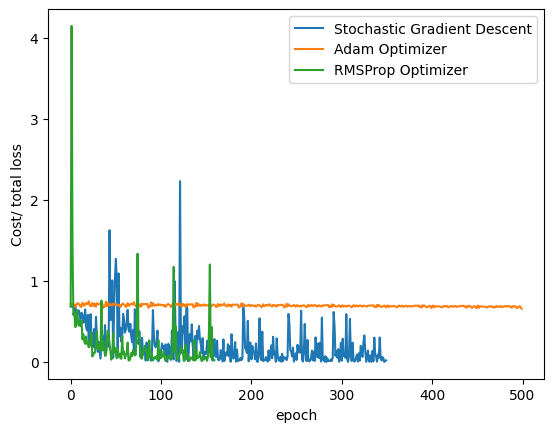

In [234]:
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_rmsprop, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

## Now solve multi-class task (2.5 points)

You are welcome to use anything you know.


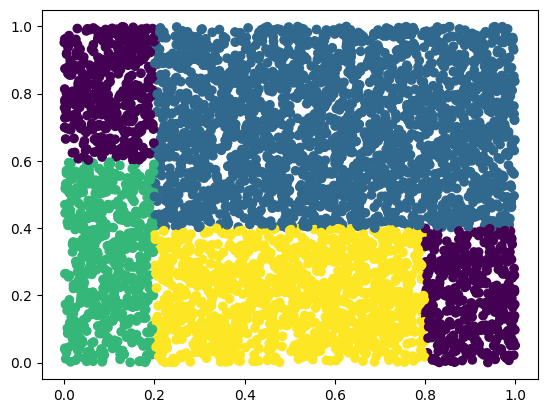

In [279]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)

target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train = data[:800]
valid = data[800:900]
test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [311]:
X_train = train[:, :-1].float()
y_train = train[:, 2].float()
X_val = valid[:, :-1].float()
y_val = valid[:, 2].float()
X_test = test[:, :-1].float()
y_test = test[:, 2].float()

In [312]:
len(torch.unique(y_train))

4

In [313]:
# ohe
y_train = torch.eye(4)[y_train.long()]
y_valid = torch.eye(4)[y_val.long()]
y_test = torch.eye(4)[y_test.long()]

In [330]:
class Multi(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2, 80)
        self.leaky = nn.LeakyReLU()
        self.hidden2 = nn.Linear(80, 40)
        self.batch_norm1 = nn.BatchNorm1d(40)
        self.relu = nn.ReLU()
        self.output = nn.Linear(40, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.leaky(x)
        x = self.hidden2(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
        return x


In [338]:
def train2(model, loss, optimizer, n_epochs, batch_size, X_train, y_train, X_val, y_val):

    batch_start = torch.arange(0, len(X_train), batch_size)
    best_acc = -np.inf   # init to negative infinity
    best_weights = None
    losses = []

    for epoch in range(n_epochs):
        model.train()

        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")

            for start in bar:

                # batches
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]

                # forward pass
                y_pred = model(X_batch)
                y_batch_float = y_batch.float()
                loss_val = loss(y_pred, y_batch)

                losses.append(loss_val.item())

                # backward pass
                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()


                acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
                bar.set_postfix(
                    loss=float(loss_val),
                    acc=float(acc)
                )

        model.eval()
        y_pred = model(X_val)

        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val, 1)).float().mean()
        acc = float(acc)

        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

        if acc > 0.99:
            break

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return model, losses


In [339]:
model = Multi()
optimizer = opt.Adam(model.parameters(), lr=0.01)
n_epochs = 70
batch_size = 10
loss = nn.CrossEntropyLoss()


res = train2(model, loss, optimizer, n_epochs, batch_size, X_train, y_train, X_val, y_valid)
model2, losses = res[0], res[1]

Epoch 69: 100%|██████████| 80/80 [00:00<00:00, 120.34batch/s, acc=0.9, loss=0.839]


## (Almost) Real task. (4 points)

This is alcohol classification task. You need to predict the target value.
Feel free to visualize and do whatever feels right to EDA and training model.
You can reuse previous models with slight changes or make a new one

Пользовалась:
- https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/
- https://discuss.pytorch.org/t/loss-function-for-multi-class-with-probabilities-as-output/60866
- https://github.com/lschmiddey/PyTorch-Multiclass-Classification/blob/master/Multiclass_Classification_on_Iris_dataset_with_Initialization_and_Dropout.ipynb

In [ ]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [ ]:
set(list(df['target'])) # всего 3 класса

{0, 1, 2}

In [ ]:
len(list(df.loc[:, df.columns != 'target'].columns)) # сколько подаем на вход?

13

In [ ]:
X = df.loc[:, df.columns != 'target'].values
y = df['target'].values

In [ ]:
x, x_val, y, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
x.shape, y.shape, x_val.shape, y_val.shape

((119, 13), (119,), (59, 13), (59,))

In [ ]:
x.shape, y.shape

((119, 13), (119,))

In [ ]:
x_train = x.reshape(-1, x.shape[1]).astype('float32')
y_train = y

x_val = x_val.reshape(-1, x_val.shape[1]).astype('float32')
y_val = y_val

In [ ]:
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self):
        self.x=torch.from_numpy(x).type(torch.FloatTensor)
        self.y=torch.from_numpy(y).type(torch.LongTensor)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [ ]:
data_set=Data()
trainloader=DataLoader(dataset=data_set, batch_size=20)

In [ ]:
class MultiClassWine(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(13, 128)
        self.act = nn.LeakyReLU()
        self.hidden2 = nn.Linear(128, 60)
        self.act2 = nn.LeakyReLU()
        self.output = nn.Linear(60, 3)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x

model = MultiClassWine()

In [ ]:
def train_model_wine(model, criterion, optimizer_ofit, trainloader, n_epochs):
    LOSS = {'training data': [], 'accuracy': []}

    for epoch in range(n_epochs):
        total_correct = 0
        total_samples = 0

        for x, y in trainloader:
            # make a prediction
            yhat = model(data_set.x)

            # calculate loss
            loss = criterion(yhat, data_set.y)

            # calculate accuracy
            _, predicted = torch.max(yhat, 1)
            correct = (predicted == data_set.y).sum().item()
            accuracy = correct / data_set.y.size(0)  # accuracy per batch

            total_correct += correct
            total_samples += data_set.y.size(0)

            # store the loss and accuracy for the training data
            LOSS['training data'].append(loss.item())
            LOSS['accuracy'].append(accuracy)

            model.eval()
            model.train()

            # clear gradient
            optimizer_ofit.zero_grad()

            # Backward pass: compute gradient of the loss with respect to all the learnable parameters
            loss.backward()

            # the step function on an Optimizer makes an update to its parameters
            optimizer_ofit.step()

        epoch_acc = total_correct / total_samples
        print('Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch, loss.item(), epoch_acc))

    return model, LOSS

In [ ]:
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
res = train_model_wine(model, criterion, optimizer_ofit, trainloader, 50)

Epoch 0, Loss: 40.0979, Accuracy: 0.3221
Epoch 1, Loss: 3.7062, Accuracy: 0.4678
Epoch 2, Loss: 1.5509, Accuracy: 0.4636
Epoch 3, Loss: 0.8286, Accuracy: 0.4874
Epoch 4, Loss: 0.8875, Accuracy: 0.5602
Epoch 5, Loss: 0.8111, Accuracy: 0.5798
Epoch 6, Loss: 0.7581, Accuracy: 0.5084
Epoch 7, Loss: 0.6911, Accuracy: 0.5364
Epoch 8, Loss: 0.6615, Accuracy: 0.6891
Epoch 9, Loss: 0.6338, Accuracy: 0.6569
Epoch 10, Loss: 0.6080, Accuracy: 0.7619
Epoch 11, Loss: 0.5815, Accuracy: 0.7563
Epoch 12, Loss: 0.5422, Accuracy: 0.7717
Epoch 13, Loss: 0.5173, Accuracy: 0.7633
Epoch 14, Loss: 0.4822, Accuracy: 0.7913
Epoch 15, Loss: 0.4454, Accuracy: 0.8277
Epoch 16, Loss: 0.3997, Accuracy: 0.8529
Epoch 17, Loss: 0.3540, Accuracy: 0.8711
Epoch 18, Loss: 0.3123, Accuracy: 0.9118
Epoch 19, Loss: 0.2684, Accuracy: 0.9174
Epoch 20, Loss: 0.2346, Accuracy: 0.9174
Epoch 21, Loss: 0.2044, Accuracy: 0.9216
Epoch 22, Loss: 0.1931, Accuracy: 0.9272
Epoch 23, Loss: 0.1658, Accuracy: 0.9314
Epoch 24, Loss: 0.1535, A

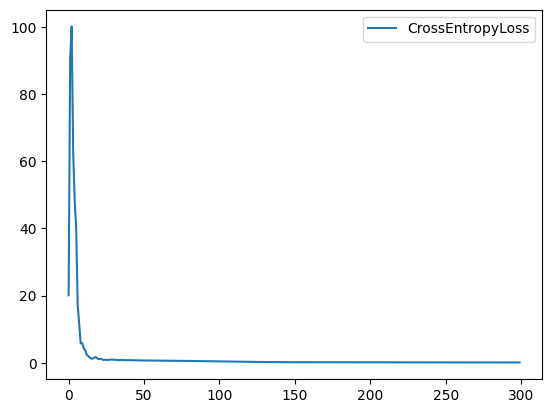

In [ ]:
plt.plot(res[1]['training data'], label = "CrossEntropyLoss")
plt.legend()
plt.show()